# On demand mapping services

The most familiar mapping services are those we often use to navigate with our phones for example: google maps.
The difference between google maps and many of the examples we have looked at so far is that we do not download data in advance, process it and then create a map. Instead we have access to data when we need it and a a _relevant_ resolution. If we want to make a global map that is 1000 pixels across then Australia is probably just a few dozen pixels wide. If we instead decide to make a map to navigate across Melbourne, then a much higher resolution is needed _but only within the boundary of the map_. 

`Cartopy` provides access to various of the online mapping services that will serve image data on demand in the form of small image tiles at a specified resolution. The tools automatically query the service and assemble the tiles to make the map but there are some tricks that we need to know before we can use them.

In [1]:
%pylab inline


import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

# from matplotlib.transforms import offset_copy

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

Populating the interactive namespace from numpy and matplotlib


Let's pre-define some features that we can add to maps later. This can be especially helpful for satellite images where it can be hard to orient the images without some overlays.

In [2]:
coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                           edgecolor=(0.0,0.0,0.0),
                           facecolor="none")

rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',
                                        edgecolor='Blue', facecolor="none")


coastline50 = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                           edgecolor=(1.0,1.0,1.0),
                           facecolor="none")

rivers50 = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m',
                                        edgecolor='Blue', facecolor="none")


lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor="blue", facecolor="blue")

ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                           edgecolor="green",
                           facecolor="blue")

In [3]:
## The full list of available interfaces is found in the source code for this one:
## https://github.com/SciTools/cartopy/blob/master/lib/cartopy/io/img_tiles.py

## Continental US terrain images
stamen_Terrain = cimgt.Stamen('terrain-background')
stamen_TerrainPlus = cimgt.Stamen('terrain')
stamen_Artist = cimgt.Stamen('watercolor')

## Mapquest satellite / streetmap images 
map_quest_aerial = cimgt.MapQuestOpenAerial()
map_quest_street = cimgt.MapQuestOSM()

## Open Street map
open_street_map = cimgt.OSM()

## Satellite Quadtree
qtree_satellite_plus = cimgt.QuadtreeTiles()

## Mapbox Satellite images 

mapbox_satellite = cimgt.MapboxTiles(map_id='satellite', 
                                     access_token='pk.eyJ1IjoibG91aXNtb3Jlc2kiLCJhIjoiY2pzeG1mZzFqMG5sZDQ0czF5YzY1NmZ4cSJ9.lpsUzmLasydBlS0IOqe5JA')

## No longer supported
# mapbox_streets = cimgt.MapboxTiles(map_id='streets', 
#                                      access_token='pk.eyJ1IjoibG91aXNtb3Jlc2kiLCJhIjoiY2pzeG1mZzFqMG5sZDQ0czF5YzY1NmZ4cSJ9.lpsUzmLasydBlS0IOqe5JA')



## Google maps image tiles ()
google_maps_street = cimgt.GoogleTiles(style="street") 
google_maps_satellite = cimgt.GoogleTiles(style="satellite") 
google_maps_terrain = cimgt.GoogleTiles(style="terrain") 

/usr/share/miniconda3/envs/jupyter/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


/usr/share/miniconda3/envs/jupyter/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


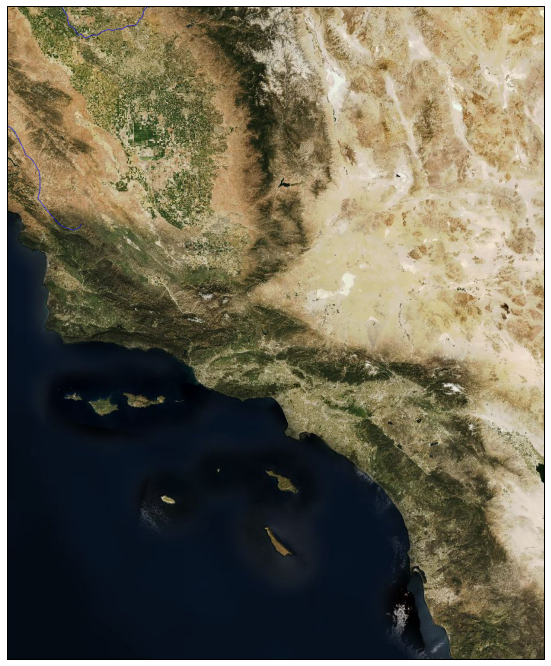

In [4]:
# Specify a region of interest

lat0 =  32  ; lat1 = 37
lon0 =  -121; lon1 = -116

map_extent = [lon0, lon1, lat0, lat1]

map_tiles = mapbox_satellite

fig = plt.figure(figsize=(12, 12), facecolor="none")
# ax = plt.axes(projection=ccrs.PlateCarree(), extent=himalaya_extent)

# Create a GeoAxes in the tile's projection.
ax = plt.axes(projection=map_tiles.crs)

# Set the size of the map
ax.set_extent(map_extent)
# Add the on-demand image - the second argument is the resolution and needs to be balanced with the 
# size of the area the map covers. 

ax.add_image(map_tiles, 8)
ax.add_feature(coastline, linewidth=1.5,  edgecolor="Black", zorder=1, alpha=0.5)
ax.add_feature(rivers,    linewidth=1.0,  edgecolor="Blue",  zorder=2, alpha=0.5)

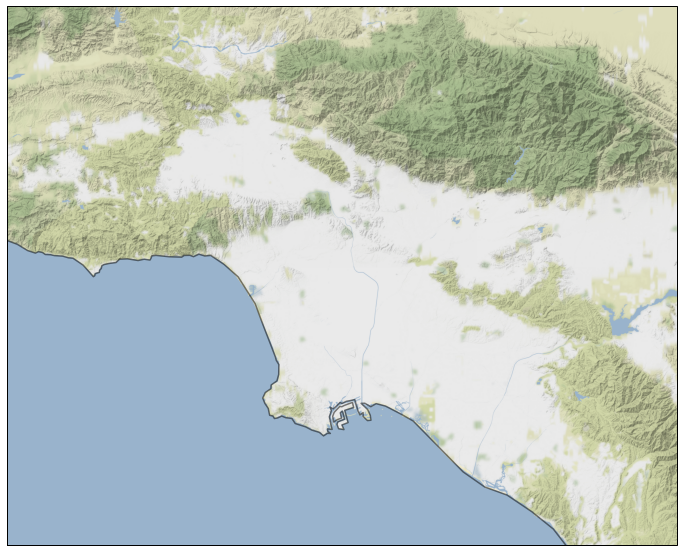

In [5]:
# Specify a region of interest

lat0 =  33.5  ; lat1 = 34.5
lon0 =  -119; lon1 = -117.5

map_extent = [lon0, lon1, lat0, lat1]

map_tiles = stamen_Terrain

fig = plt.figure(figsize=(12, 12), facecolor="none")
# ax = plt.axes(projection=ccrs.PlateCarree(), extent=himalaya_extent)

# Create a GeoAxes in the tile's projection.
ax = plt.axes(projection=map_tiles.crs)

# Set the size of the map
ax.set_extent(map_extent)
# Add the on-demand image - the second argument is the resolution and needs to be balanced with the 
# size of the area the map covers. 

ax.add_image(map_tiles, 11)
ax.add_feature(coastline, linewidth=1.5,  edgecolor="Black", zorder=1, alpha=0.5)
ax.add_feature(rivers,    linewidth=1.0,  edgecolor="Blue",  zorder=2, alpha=0.5)

In [6]:
fig.savefig("LaBasinTerrain-stamen.png", dpi=300)

/usr/share/miniconda3/envs/jupyter/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/physical/ne_50m_rivers_lake_centerlines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


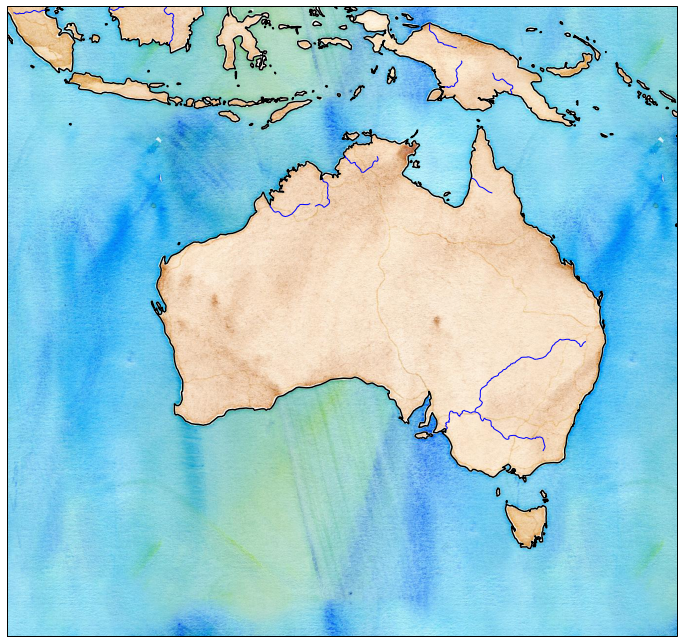

In [7]:
# Specify a region of interest

lat0 =  -45  ; lat1 = 0
lon0 =  100  ; lon1 = 160

map_extent = [lon0, lon1, lat0, lat1]

map_tiles = stamen_Artist

fig = plt.figure(figsize=(12, 12), facecolor="none")

ax = plt.axes(projection=map_tiles.crs)

# Set the size of the map
ax.set_extent(map_extent)

# Add the on-demand image - the second argument is the resolution and needs to be balanced with the 
# size of the area the map covers. 

ax.add_image(map_tiles, 5)

ax.add_feature(coastline50, linewidth=1.5,  edgecolor="Black", zorder=1)
ax.add_feature(rivers50,    linewidth=1.0,  edgecolor="Blue",  zorder=2)

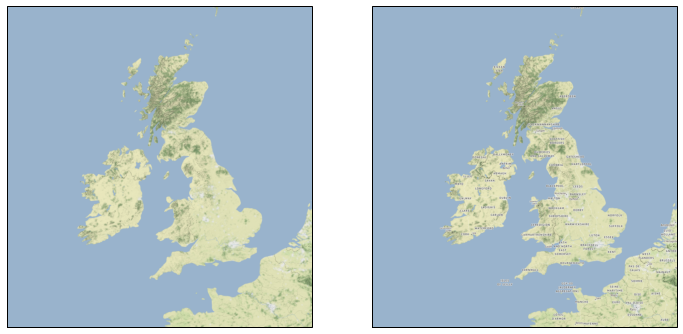

In [8]:
## Mapquest - Je ne t'aime plus 

lat0 =   48  ; lat1 = 60
lon0 =  -15  ; lon1 = 5

map_extent = [lon0, lon1, lat0, lat1]


fig  = plt.figure(figsize=(12, 12), facecolor="none")
ax1  = plt.subplot(121, projection=stamen_Terrain.crs)
ax2  = plt.subplot(122, projection=stamen_TerrainPlus.crs)

ax1.set_extent(map_extent)
ax2.set_extent(map_extent)

ax1.add_image(stamen_Terrain, 7)
ax2.add_image(stamen_TerrainPlus, 7)

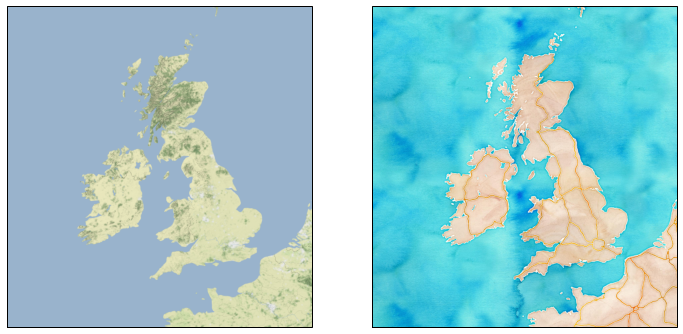

In [9]:
lat0 =   48  ; lat1 = 60
lon0 =  -15  ; lon1 = 5

map_extent = [lon0, lon1, lat0, lat1]

fig  = plt.figure(figsize=(12, 12), facecolor="none")
ax1  = plt.subplot(121, projection=stamen_Terrain.crs)
ax2  = plt.subplot(122, projection=google_maps_terrain.crs)

ax1.set_extent(map_extent)
ax2.set_extent(map_extent)

ax1.add_image(stamen_Terrain,      7)
ax2.add_image(stamen_Artist,       7)

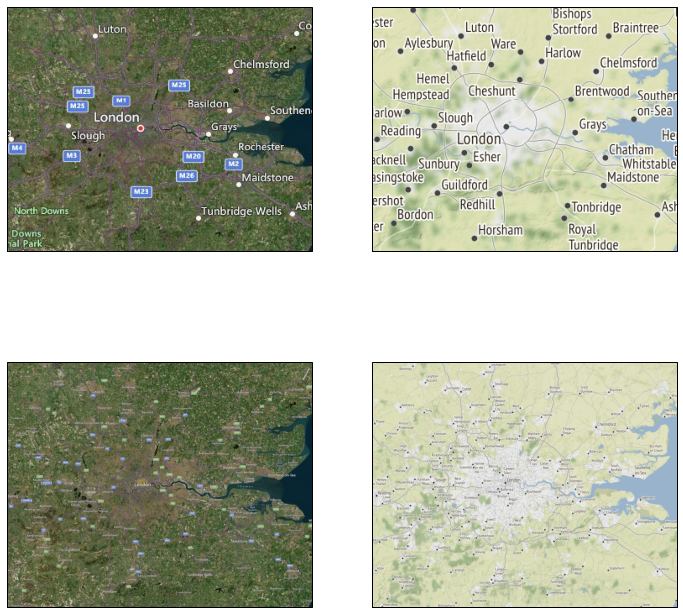

In [10]:
# To test what the influence of the resolution parameter is on the map that is returned ... 

lat0 =   51  ; lat1 = 52
lon0 =  -1  ; lon1 = 1

map_extent = [lon0, lon1, lat0, lat1]


maptype1 = mapbox_satellite
maptype2 = stamen_TerrainPlus


## Could also try these ... 

# maptype1 = open_street_map
maptype1 = cimgt.QuadtreeTiles()


fig  = plt.figure(figsize=(12, 12), facecolor="none")
ax1  = plt.subplot(221, projection=maptype1.crs)
ax2  = plt.subplot(222, projection=maptype2.crs)
ax3  = plt.subplot(223, projection=maptype1.crs)
ax4  = plt.subplot(224, projection=maptype2.crs)

ax1.set_extent(map_extent)
ax2.set_extent(map_extent)
ax3.set_extent(map_extent)
ax4.set_extent(map_extent)

ax1.add_image(maptype1, 8)
ax2.add_image(maptype2, 8)

ax3.add_image(maptype1, 10)
ax4.add_image(maptype2, 10)

In [11]:
fig.savefig("ResolutionTest.png", dpi=600)

See how well that worked by opening the [full-size image](./ResolutionTest.png). 

There really is a lot of detail available, but you can also see how long it takes to download and build the different resolutions. There is something of an art to finding the right balance. 

You may also find that very high resolution output results in memory errors. If so, restart the kernel and try again with a small image or lower dpi.

In [12]:
## For fun, this is the street where I grew up ... 

lat0 =   51.585 ; lat1 = 51.595
lon0 =   0.018   ; lon1 = 0.033

map_extent = [lon0, lon1, lat0, lat1]


figE18  = plt.figure(figsize=(12, 6), facecolor="none")
ax1  = plt.subplot(121, projection=google_maps_street.crs)
ax2  = plt.subplot(122, projection=google_maps_satellite.crs)

ax1.set_extent(map_extent)
ax2.set_extent(map_extent)

ax1.add_image(google_maps_street, 17,    )
ax2.add_image(open_street_map, 17)

ValueError: A non-empty list of tiles should be provided to merge.

<Figure size 864x432 with 2 Axes>

In [13]:
figE18.savefig("LondonE18.png", dpi=900)

ValueError: A non-empty list of tiles should be provided to merge.

Again, open the [full-size image](./LondonE18.png) to see how well that worked